# 1. Import

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
PATH = '../data/online_shoppers_intention.csv'

In [4]:
data = pd.read_csv(PATH)
data.head(5)

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  
2        1       9            3  Returning_Visitor    False    False  
3        2       2            4  Returning_Visitor    False    False  
4        3       1            4  Returning_Visitor     True    False

**Гипотезы:**
- "PageValue" сильно коррелирует с "Revenue", при значениях "PageValue" равных 0, скорее всего на странице нельзя купить товар, или на ней никто ничего не покупает.
- Чем больше "ProductRelated_Duration", тем больше вероятность конверсии
- Чем больше "ProductRelated", тем больше вероятность конверсии
- Чем ближе "SpecialDay" к 0.6 тем больше вероятность конверсии, если не учитывать обычные (при которых "SpecialDay" равен 0)

In [71]:
data[data.Administrative != 0]['VisitorType'].value_counts()

Returning_Visitor    5336
New_Visitor          1193
Other                  33
Name: VisitorType, dtype: int64

In [66]:
data[data.PageValues == 0.0]['Revenue'].value_counts()
data[data.PageValues != 0.0]['Revenue'].value_counts()

False    9230
True      370
Name: Revenue, dtype: int64

In [69]:
370 / 9230

0.04008667388949079

In [67]:
data[data.PageValues != 0.0]['Revenue'].value_counts()

True     1538
False    1192
Name: Revenue, dtype: int64

<AxesSubplot:xlabel='Revenue', ylabel='PageValues'>

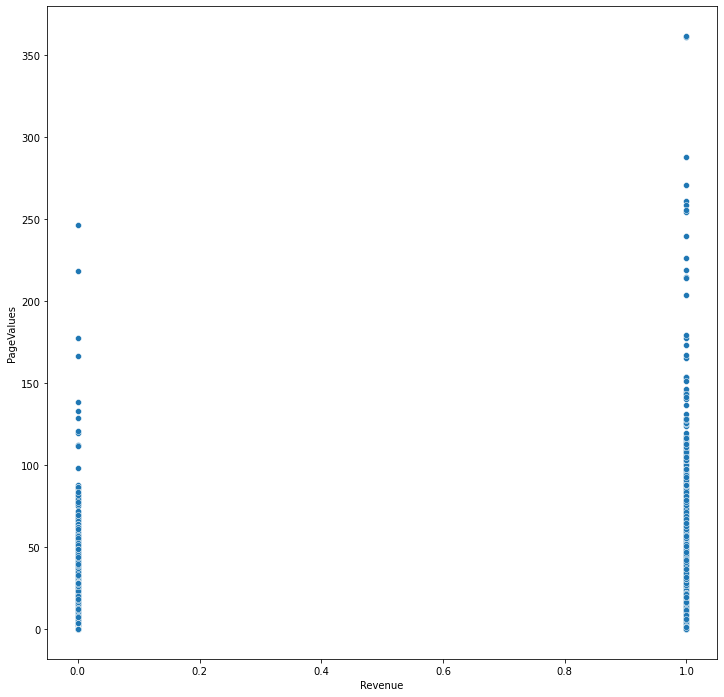

In [68]:
sns.scatterplot(data=data,
               x='Revenue',
               y='PageValues')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [6]:
data.describe()

Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         2.315166                80.818611       0.503569   
std          3.321784               176.779107       1.270156   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 7.500000       0.000000   
75%          4.000000                93.256250       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            12330.000000    12330.000000             12330.000000   
mean                34.472398       31.731468              1194.746220   
std                140.749294       44.475503              1913.669288   
min                  0.000000        0.000000                 0.000000   
25%                  0.000000        7.000000               184.137500   
50%                  0.000000       18.000000               598.936905   
75%                  0.000000       38.000000              1464.157214   
max               2549.375000      705.000000             63973.522230   

        BounceRates     ExitRates    PageValues    SpecialDay  \
count  12330.000000  12330.000000  12330.000000  12330.000000   
mean       0.022191      0.043073      5.889258      0.061427   
std        0.048488      0.048597     18.568437      0.198917   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.014286      0.000000      0.000000   
50%        0.003112      0.025156      0.000000      0.000000   
75%        0.016813      0.050000      0.000000      0.000000   
max        0.200000      0.200000    361.763742      1.000000   

       OperatingSystems       Browser        Region   TrafficType  
count      12330.000000  12330.000000  12330.000000  12330.000000  
mean           2.124006      2.357097      3.147364      4.069586  
std            0.911325      1.717277      2.401591      4.025169  
min            1.000000      1.000000      1.000000      1.000000  
25%            2.000000      2.000000      1.000000      2.000000  
50%            2.000000      2.000000      3.000000      2.000000  
75%            3.000000      2.000000      4.000000      4.000000  
max            8.000000     13.000000      9.000000     20.000000

In [8]:
data.Month.value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

In [10]:
data.VisitorType.value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

In [11]:
data.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [15]:
data.SpecialDay.unique()

array([0. , 0.4, 0.8, 1. , 0.2, 0.6])

<BarContainer object of 311 artists>

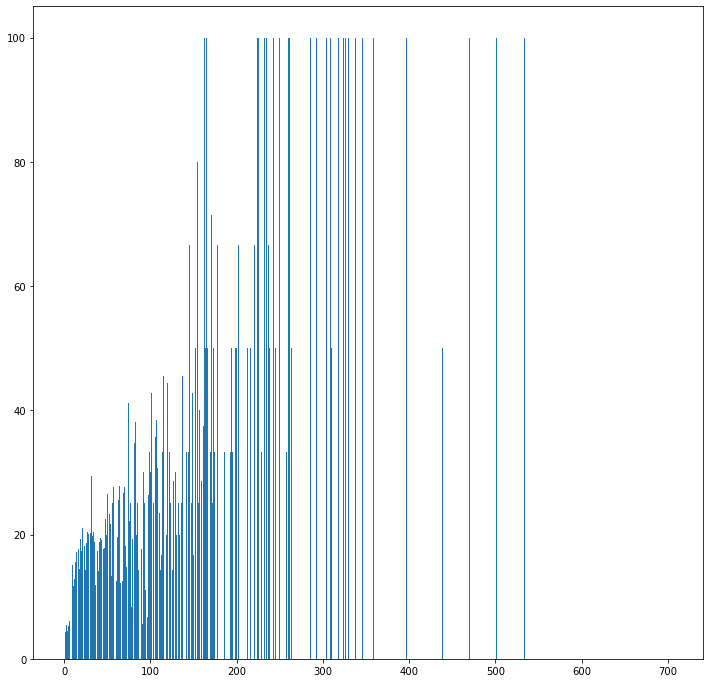

In [210]:
gg = data.groupby('ProductRelated')['Revenue'].agg(lambda x: (x).sum() * 100 / len(x))
a = gg.index
b = gg.values
plt.bar(a, b)

In [202]:
bins = [-1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 2]
labels = np.arange(len(bins)- 1)
data['PageValueBins'] = pd.cut(data.PageValues, bins=bins, labels=labels)
data

Administrative  Administrative_Duration  Informational  \
0                   0                      0.0              0   
1                   0                      0.0              0   
2                   0                      0.0              0   
3                   0                      0.0              0   
4                   0                      0.0              0   
...               ...                      ...            ...   
12325               3                    145.0              0   
12326               0                      0.0              0   
12327               0                      0.0              0   
12328               4                     75.0              0   
12329               0                      0.0              0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                         0.0               1                 0.000000   
1                         0.0               2                64.000000   
2                         0.0               1                 0.000000   
3                         0.0               2                 2.666667   
4                         0.0              10               627.500000   
...                       ...             ...                      ...   
12325                     0.0              53              1783.791667   
12326                     0.0               5               465.750000   
12327                     0.0               6               184.250000   
12328                     0.0              15               346.000000   
12329                     0.0               3                21.250000   

       BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.200000   0.200000    0.000000         0.0   Feb                 1   
1         0.000000   0.100000    0.000000         0.0   Feb                 2   
2         0.200000   0.200000    0.000000         0.0   Feb                 4   
3         0.050000   0.140000    0.000000         0.0   Feb                 3   
4         0.020000   0.050000    0.000000         0.0   Feb                 3   
...            ...        ...         ...         ...   ...               ...   
12325     0.007143   0.029031   12.241717         0.0   Dec                 4   
12326     0.000000   0.021333    0.000000         0.0   Nov                 3   
12327     0.083333   0.086667    0.000000         0.0   Nov                 3   
12328     0.000000   0.021053    0.000000         0.0   Nov                 2   
12329     0.000000   0.066667    0.000000         0.0   Nov                 3   

       Browser  Region  TrafficType        VisitorType  Weekend  Revenue  \
0            1       1            1  Returning_Visitor    False    False   
1            2       1            2  Returning_Visitor    False    False   
2            1       9            3  Returning_Visitor    False    False   
3            2       2            4  Returning_Visitor    False    False   
4            3       1            4  Returning_Visitor     True    False   
...        ...     ...          ...                ...      ...      ...   
12325        6       1            1  Returning_Visitor     True    False   
12326        2       1            8  Returning_Visitor     True    False   
12327        2       1           13  Returning_Visitor     True    False   
12328        2       3           11  Returning_Visitor    False    False   
12329        2       1            2        New_Visitor     True    False   

      ProductRelatedBins PageValueBins  
0                      0             0  
1                      0             0  
2                      0             0  
3                      0             0  
4                      1             0  
...                  ...           ...  
12325                  4           NaN  
12326                  1             0  
12327                  0             0  
12328                  0             0  


<BarContainer object of 10 artists>

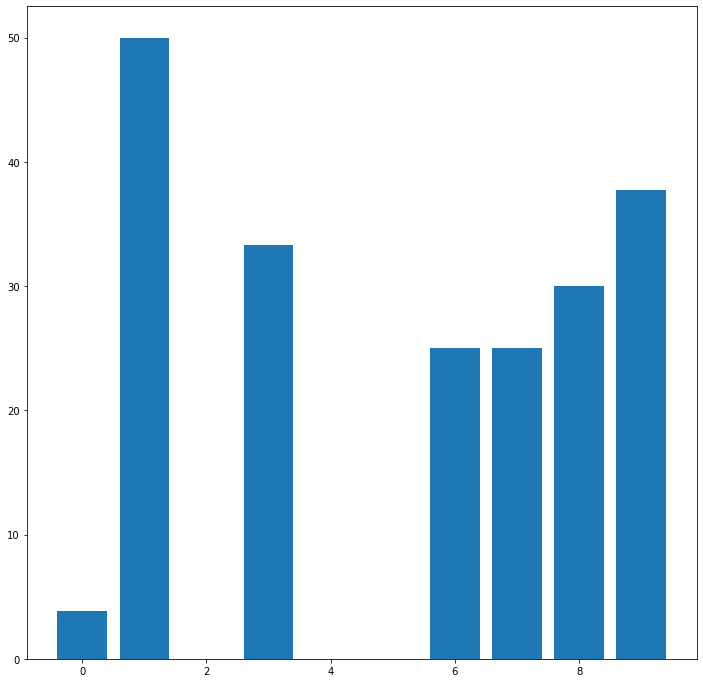

In [203]:
gg = data.groupby('PageValueBins')['Revenue'].agg(lambda x: (x).sum() * 100 / len(x)).dropna()
b = gg.index
p = gg.values

plt.bar(b, p)

In [189]:
bins = np.arange(-1, max(data.ProductRelated_Duration) + 2, 400)
labels = np.arange(len(bins)- 1)
data['ProductRelatedBins'] = pd.cut(data.ProductRelated_Duration, bins=bins, labels=labels)
data

Administrative  Administrative_Duration  Informational  \
0                   0                      0.0              0   
1                   0                      0.0              0   
2                   0                      0.0              0   
3                   0                      0.0              0   
4                   0                      0.0              0   
...               ...                      ...            ...   
12325               3                    145.0              0   
12326               0                      0.0              0   
12327               0                      0.0              0   
12328               4                     75.0              0   
12329               0                      0.0              0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                         0.0               1                 0.000000   
1                         0.0               2                64.000000   
2                         0.0               1                 0.000000   
3                         0.0               2                 2.666667   
4                         0.0              10               627.500000   
...                       ...             ...                      ...   
12325                     0.0              53              1783.791667   
12326                     0.0               5               465.750000   
12327                     0.0               6               184.250000   
12328                     0.0              15               346.000000   
12329                     0.0               3                21.250000   

       BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.200000   0.200000    0.000000         0.0   Feb                 1   
1         0.000000   0.100000    0.000000         0.0   Feb                 2   
2         0.200000   0.200000    0.000000         0.0   Feb                 4   
3         0.050000   0.140000    0.000000         0.0   Feb                 3   
4         0.020000   0.050000    0.000000         0.0   Feb                 3   
...            ...        ...         ...         ...   ...               ...   
12325     0.007143   0.029031   12.241717         0.0   Dec                 4   
12326     0.000000   0.021333    0.000000         0.0   Nov                 3   
12327     0.083333   0.086667    0.000000         0.0   Nov                 3   
12328     0.000000   0.021053    0.000000         0.0   Nov                 2   
12329     0.000000   0.066667    0.000000         0.0   Nov                 3   

       Browser  Region  TrafficType        VisitorType  Weekend  Revenue  \
0            1       1            1  Returning_Visitor    False    False   
1            2       1            2  Returning_Visitor    False    False   
2            1       9            3  Returning_Visitor    False    False   
3            2       2            4  Returning_Visitor    False    False   
4            3       1            4  Returning_Visitor     True    False   
...        ...     ...          ...                ...      ...      ...   
12325        6       1            1  Returning_Visitor     True    False   
12326        2       1            8  Returning_Visitor     True    False   
12327        2       1           13  Returning_Visitor     True    False   
12328        2       3           11  Returning_Visitor    False    False   
12329        2       1            2        New_Visitor     True    False   

      ProductRelatedBins  
0                      0  
1                      0  
2                      0  
3                      0  
4                      1  
...                  ...  
12325                  4  
12326                  1  
12327                  0  
12328                  0  
12329                  0  

[12330 rows x 19 columns]

<BarContainer object of 52 artists>

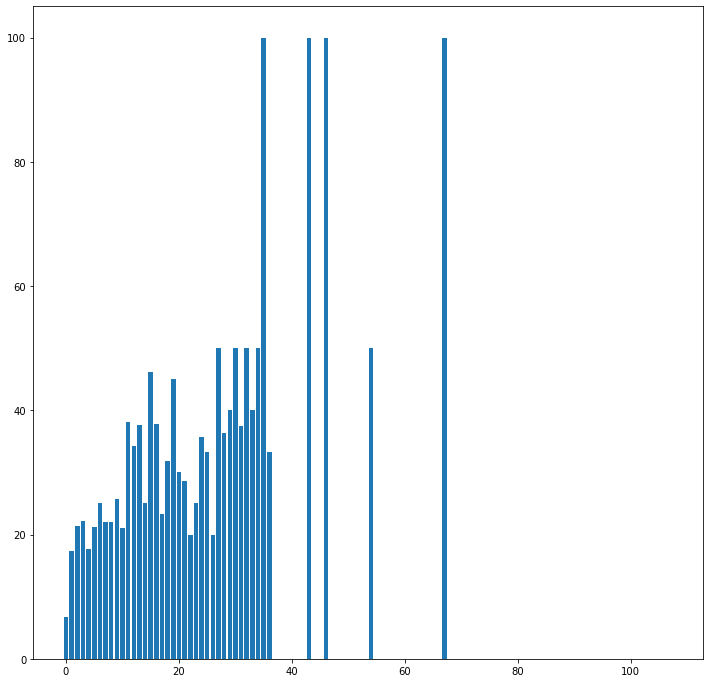

In [190]:
gg = data.groupby('ProductRelatedBins')['Revenue'].agg(lambda x: (x).sum() * 100 / len(x)).dropna()
b = gg.index
p = gg.values

plt.bar(b, p)

(0.0, 5000.0)

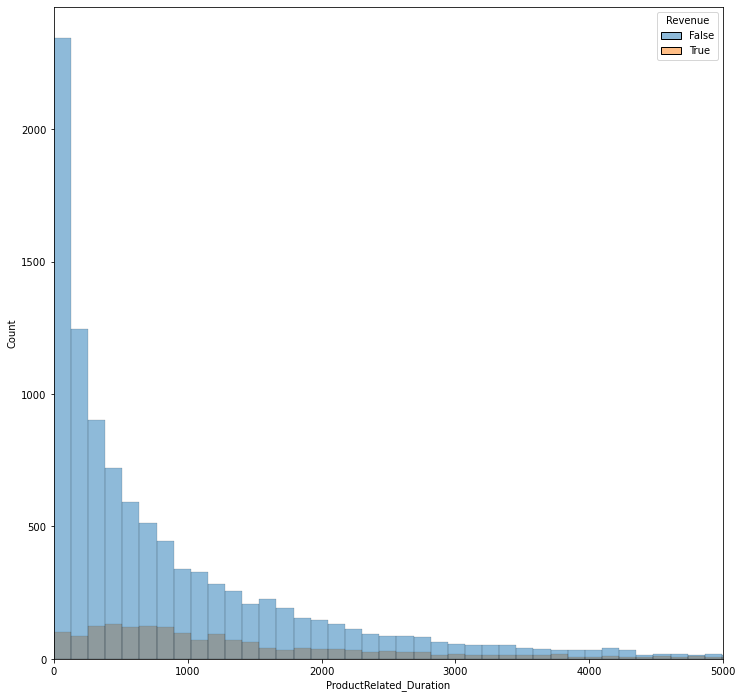

In [61]:
g = sns.histplot(data=data,
              x='ProductRelated_Duration',
              hue='Revenue',
              bins=500)
g.set_xlim(0, 5000)

In [41]:
def calc_conv(x):
    return (x == 1).sum() / len(x)

In [42]:
data.groupby('VisitorType')['Revenue'].agg(calc_conv)

VisitorType
New_Visitor          0.249115
Other                0.188235
Returning_Visitor    0.139323
Name: Revenue, dtype: float64

In [ ]:
data.groupby('')

<AxesSubplot:xlabel='VisitorType', ylabel='count'>

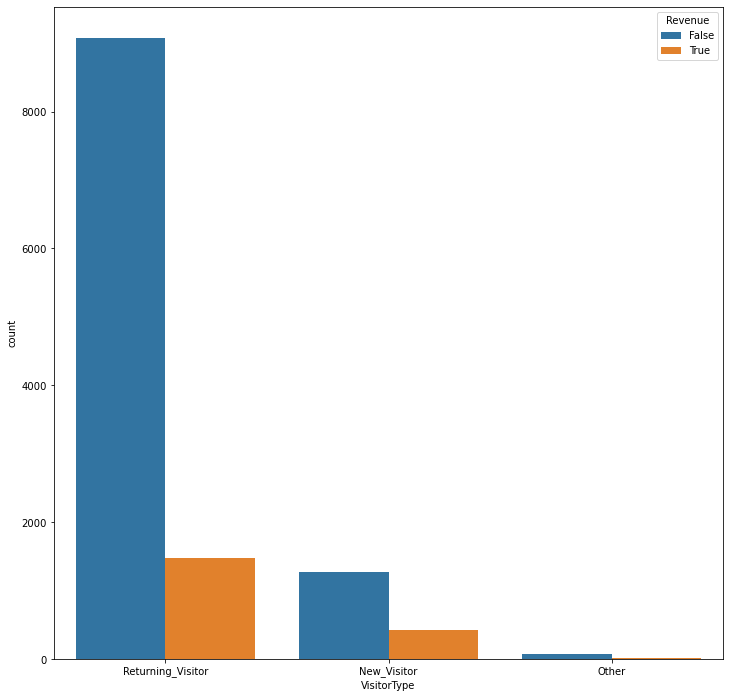

In [162]:
sns.countplot(data=data,
              x='VisitorType',
              hue='Revenue')

<AxesSubplot:xlabel='Month', ylabel='count'>

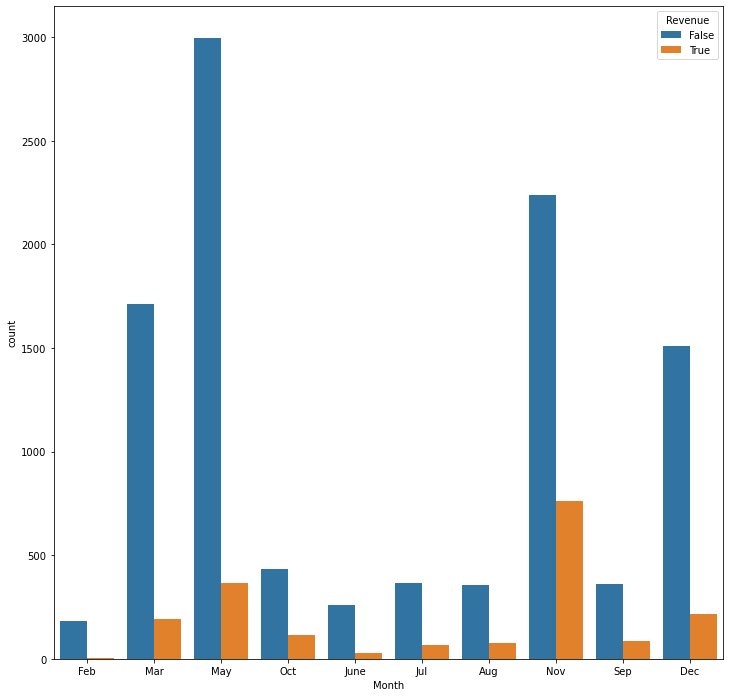

In [37]:
sns.countplot(data=data,
              x='Month',
              hue='Revenue')

In [43]:
data.groupby('Month')['Revenue'].agg(calc_conv)

Month
Aug     0.175520
Dec     0.125072
Feb     0.016304
Jul     0.152778
June    0.100694
Mar     0.100682
May     0.108502
Nov     0.253502
Oct     0.209472
Sep     0.191964
Name: Revenue, dtype: float64

<AxesSubplot:xlabel='Region', ylabel='count'>

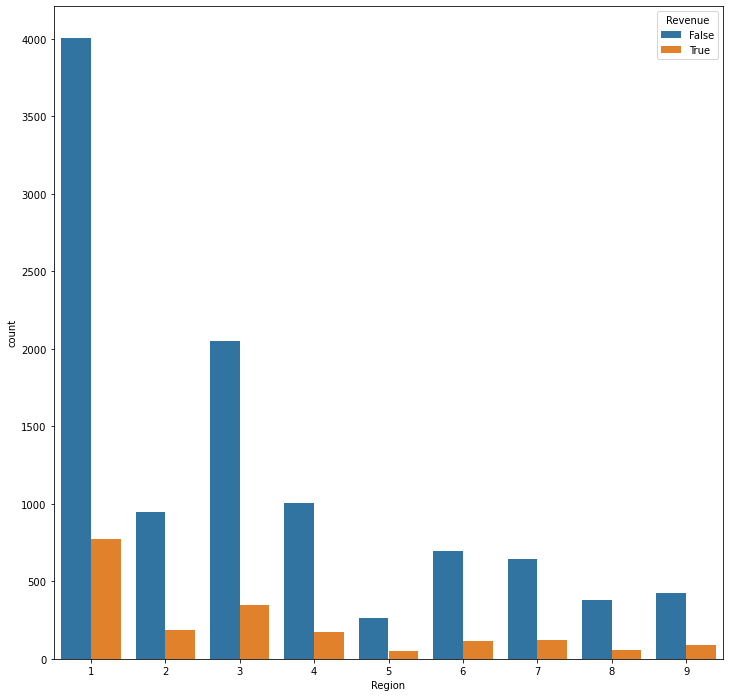

In [38]:
sns.countplot(data=data,
              x='Region',
              hue='Revenue')

In [44]:
data.groupby('Region')['Revenue'].agg(calc_conv)

Region
1    0.161297
2    0.165493
3    0.145235
4    0.148054
5    0.163522
6    0.139130
7    0.156373
8    0.129032
9    0.168297
Name: Revenue, dtype: float64

<AxesSubplot:xlabel='OperatingSystems', ylabel='count'>

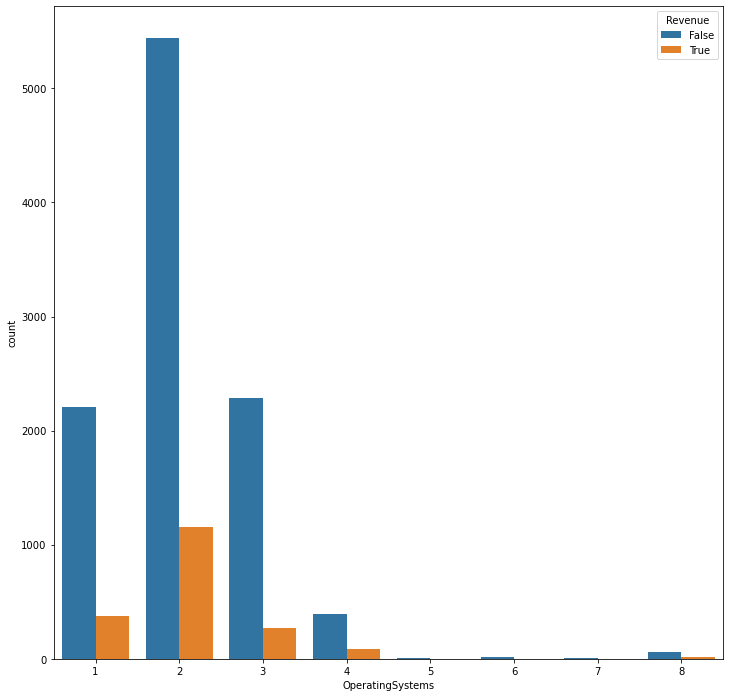

In [39]:
sns.countplot(data=data,
              x='OperatingSystems',
              hue='Revenue')

In [45]:
data.groupby('OperatingSystems')['Revenue'].agg(calc_conv)

OperatingSystems
1    0.146615
2    0.174973
3    0.104892
4    0.177824
5    0.166667
6    0.105263
7    0.142857
8    0.215190
Name: Revenue, dtype: float64

<AxesSubplot:xlabel='Weekend', ylabel='count'>

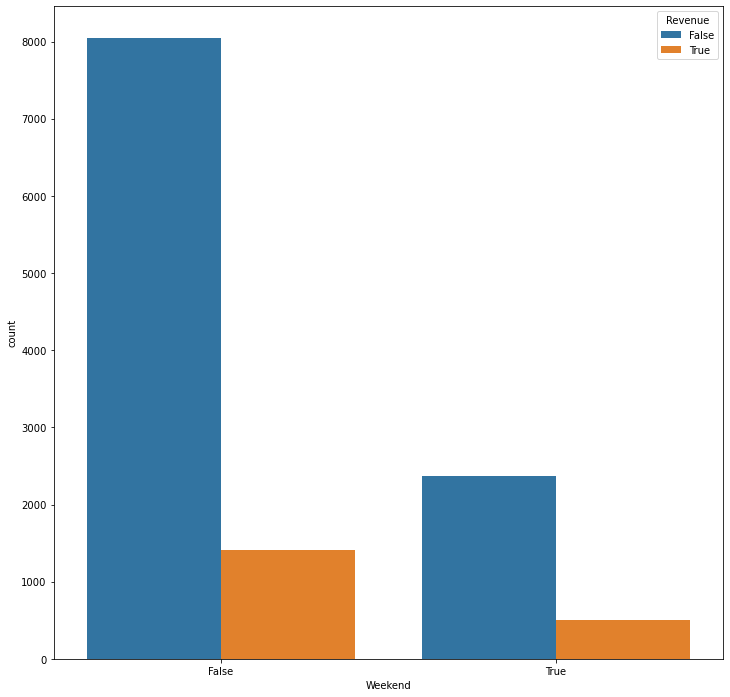

In [40]:
sns.countplot(data=data,
              x='Weekend',
              hue='Revenue')

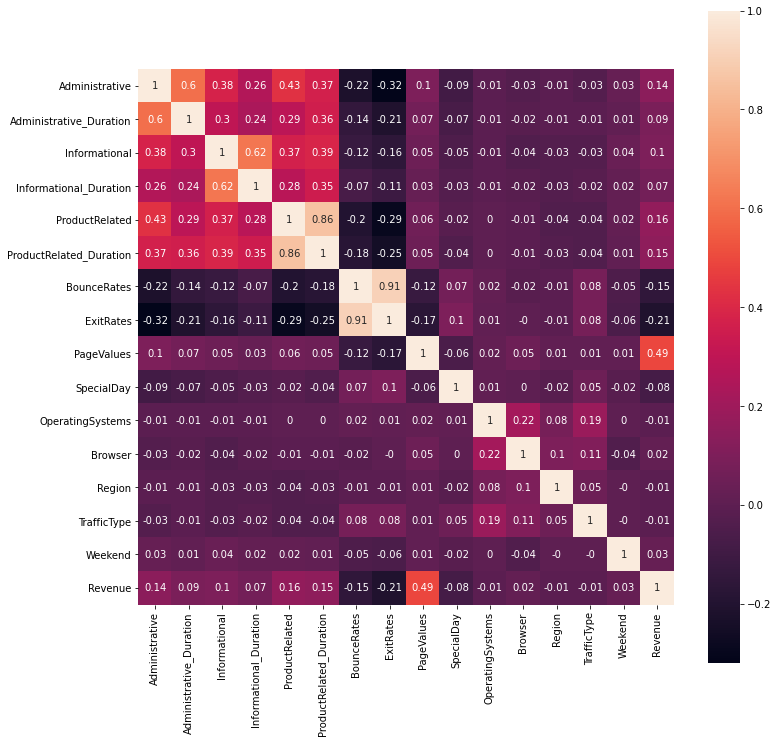

In [19]:
plt.rcParams["figure.figsize"] = (12, 12)

sns.heatmap(
    data=data.corr().round(2),
    square=True,
    annot=True,
);

In [205]:
data.groupby('SpecialDay')['Revenue'].agg(lambda x: (x).sum() * 100 / len(x))

SpecialDay
0.0    16.526762
0.2     7.865169
0.4     5.349794
0.6     8.262108
0.8     3.384615
1.0     6.493506
Name: Revenue, dtype: float64

<AxesSubplot:xlabel='SpecialDay', ylabel='count'>

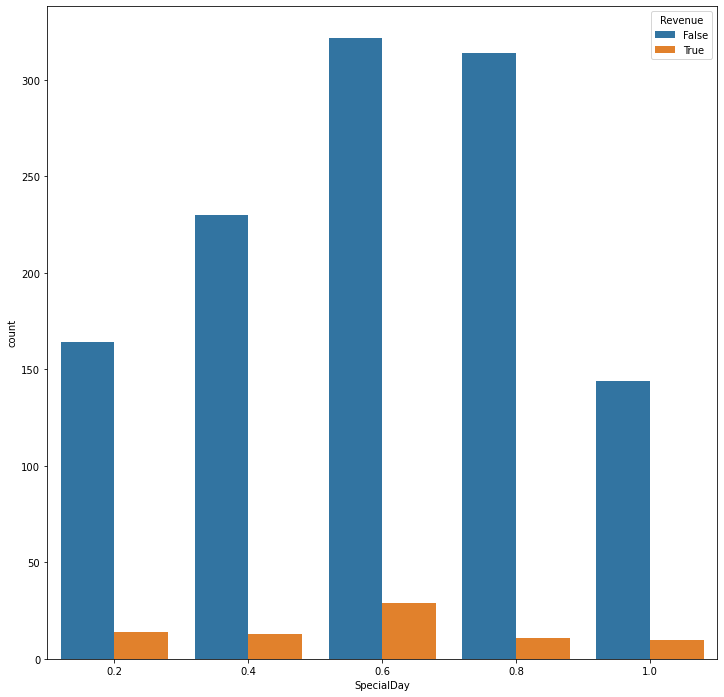

In [211]:
sns.countplot(data=data[data.SpecialDay != 0.0],
              x='SpecialDay',
              hue='Revenue')

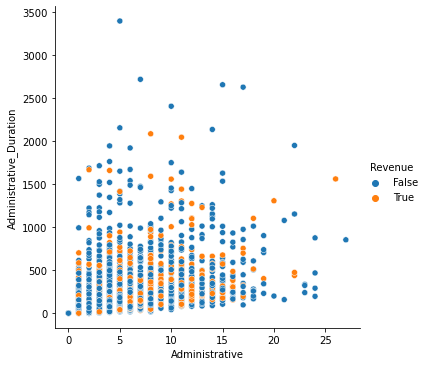

In [23]:
sns.relplot(data=data,
            x='Administrative',
            y='Administrative_Duration',
            hue='Revenue',
            kind='scatter' 
           )

In [35]:
numeric_col = data.select_dtypes(include='number').columns
numeric_col

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType'],
      dtype='object')

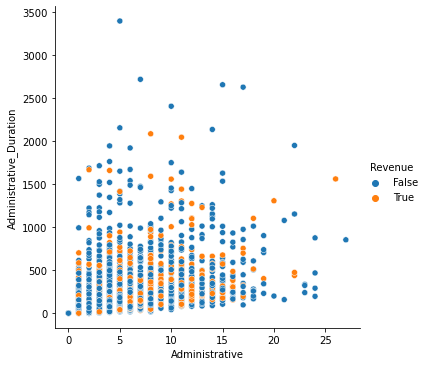

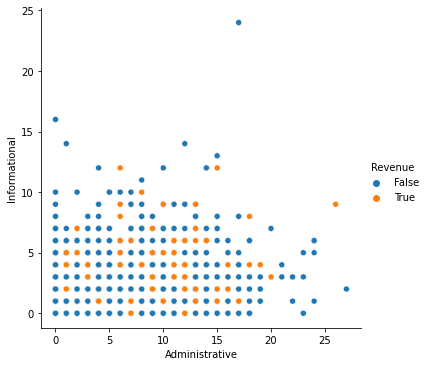

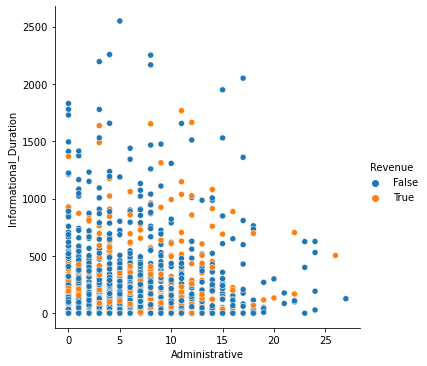

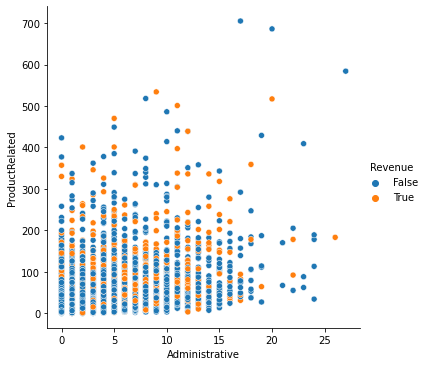

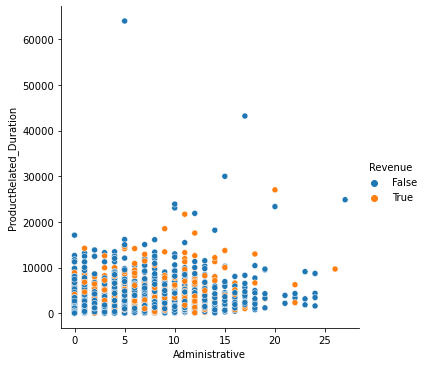

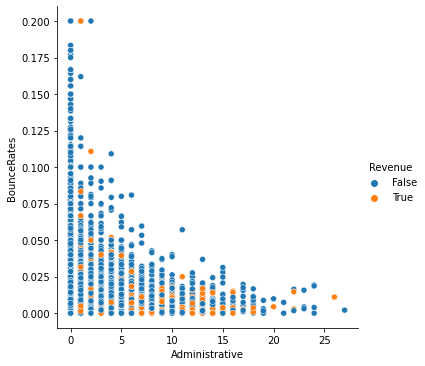

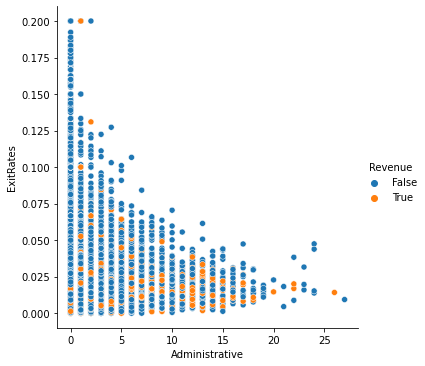

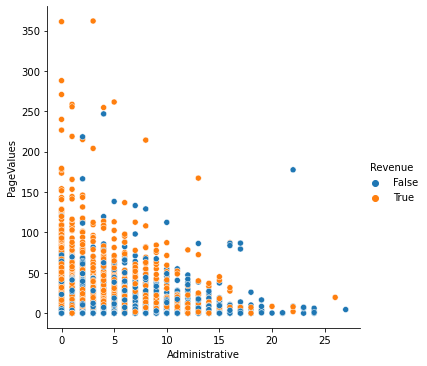

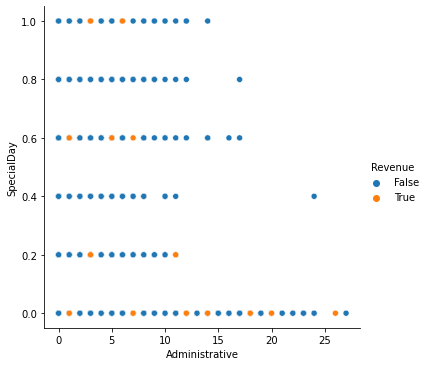

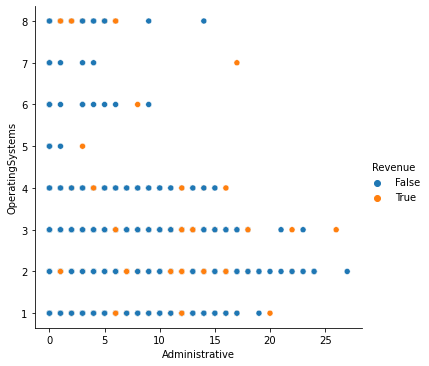

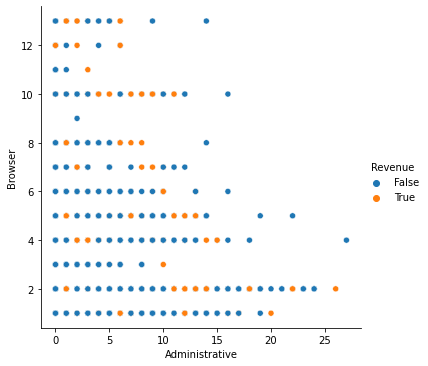

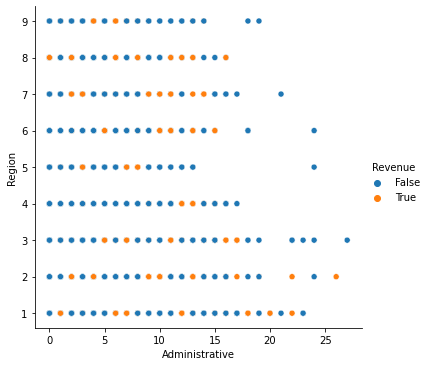

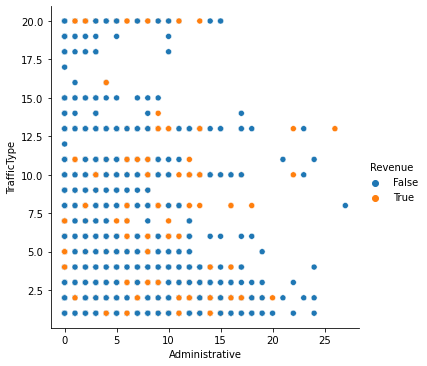

In [34]:
for col in numeric_col:
    if col != 'Administrative':
        sns.relplot(data=data,
                    x='Administrative',
                    y=col,
                    hue='Revenue',
                    kind='scatter' 
                   )

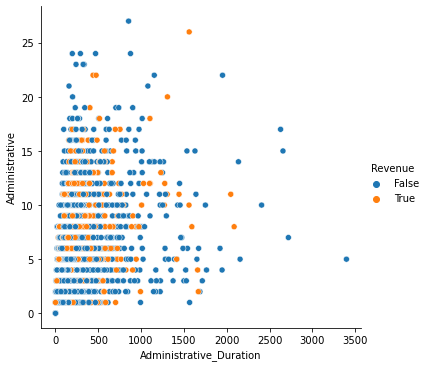

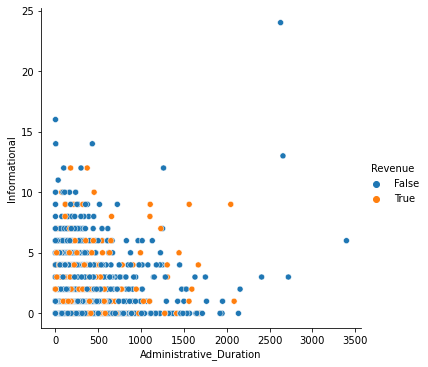

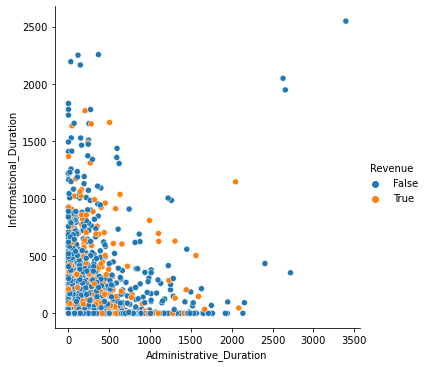

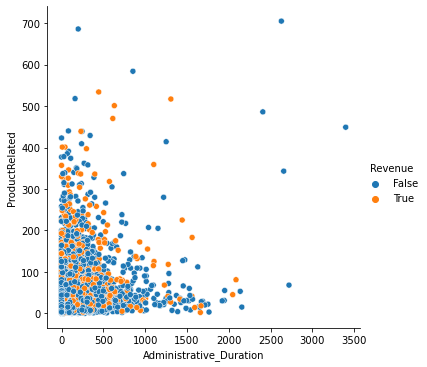

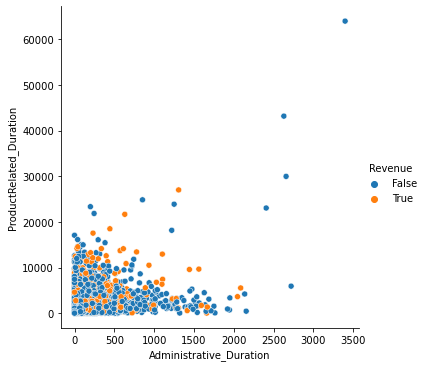

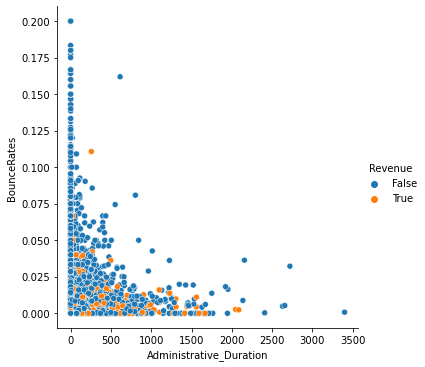

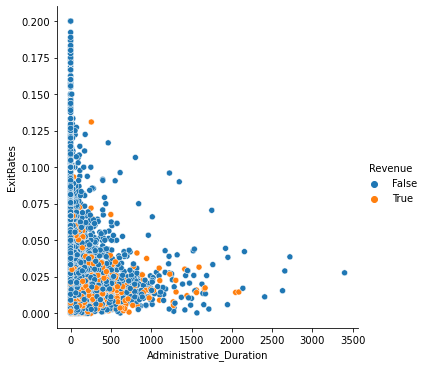

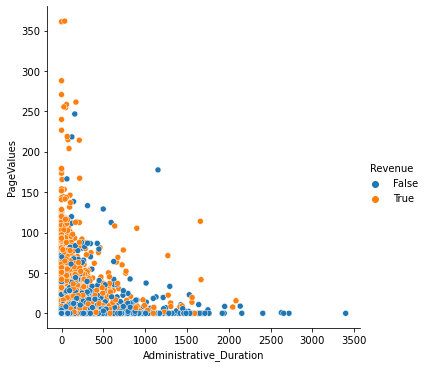

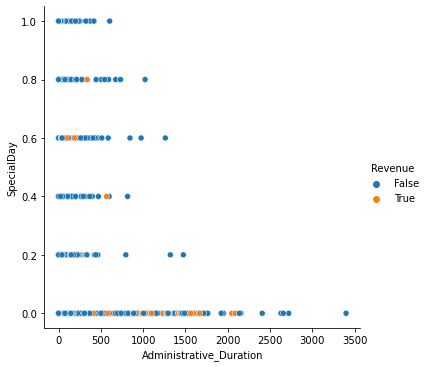

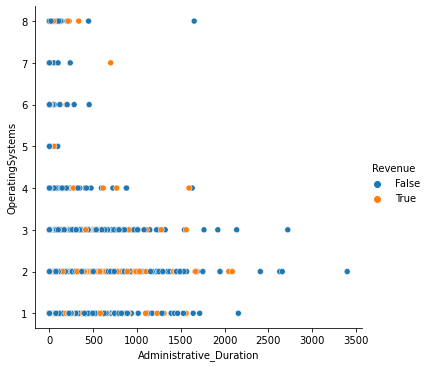

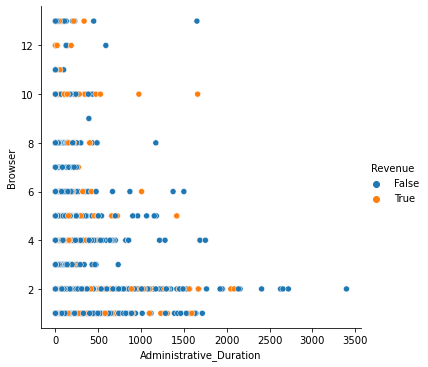

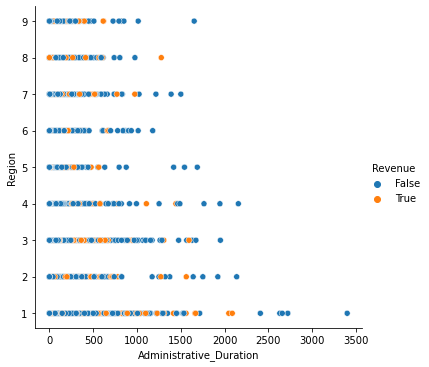

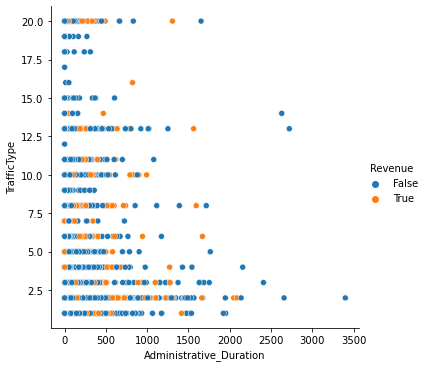

In [36]:
for col in numeric_col:
    if col != 'Administrative_Duration':
        sns.relplot(data=data,
                    x='Administrative_Duration',
                    y=col,
                    hue='Revenue',
                    kind='scatter' 
                   )

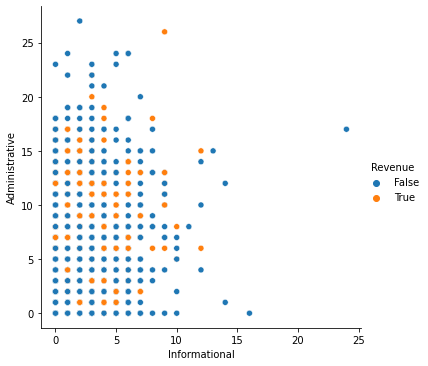

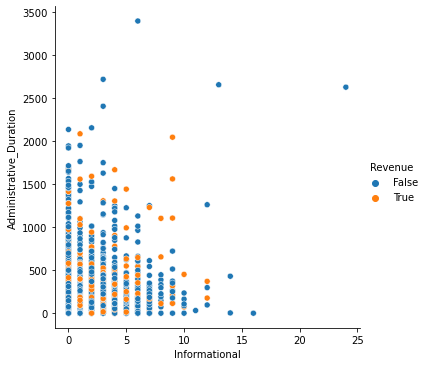

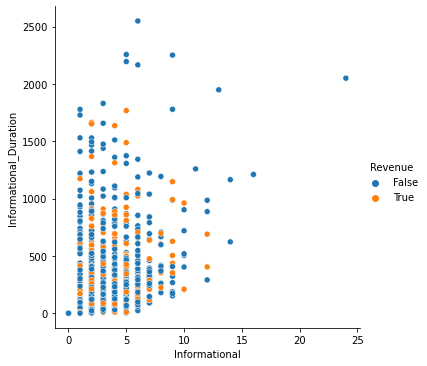

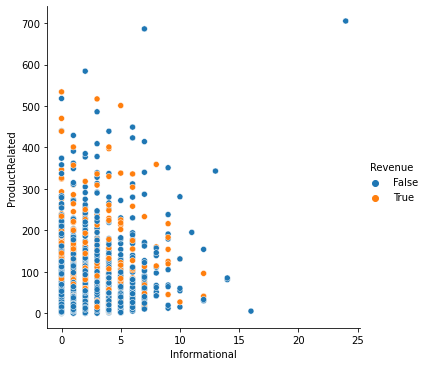

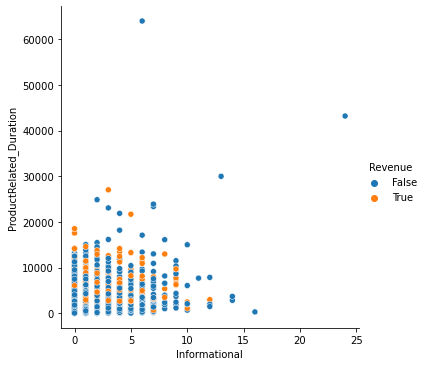

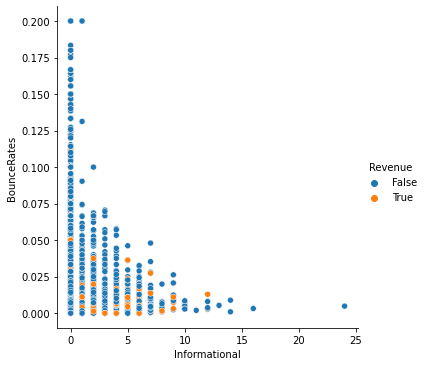

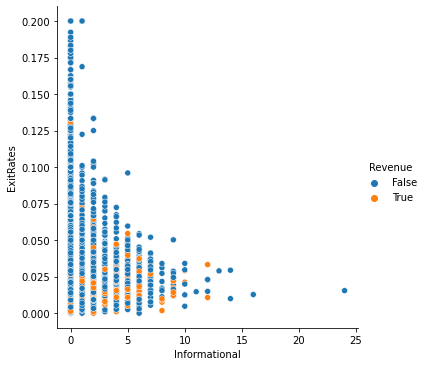

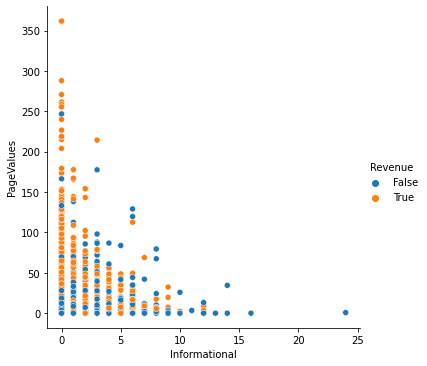

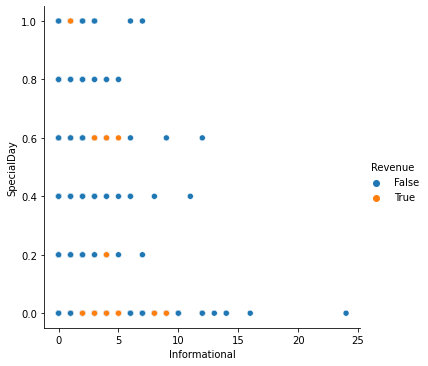

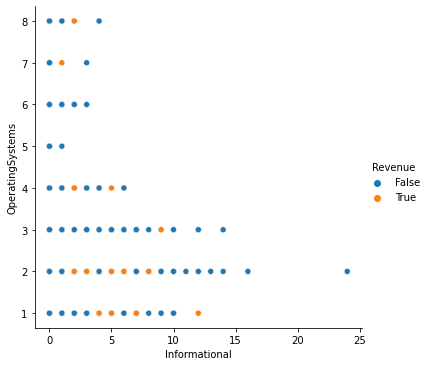

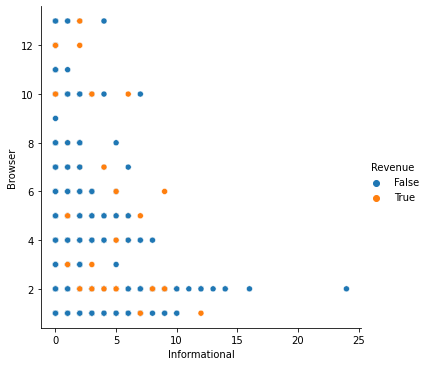

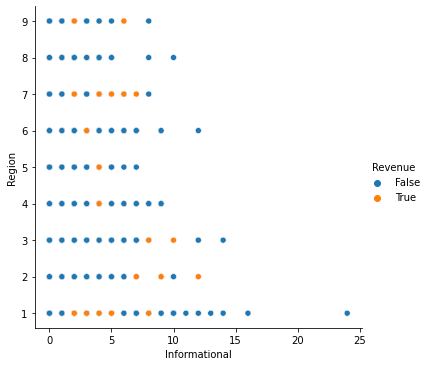

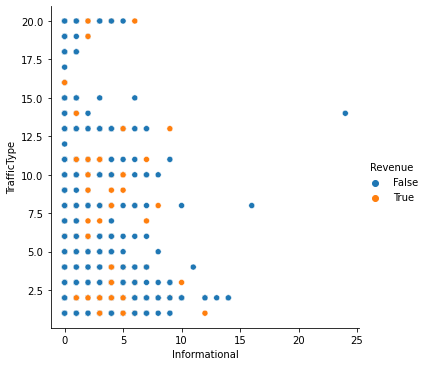

In [46]:
for col in numeric_col:
    if col != 'Informational':
        sns.relplot(data=data,
                    x='Informational',
                    y=col,
                    hue='Revenue',
                    kind='scatter' 
                   )

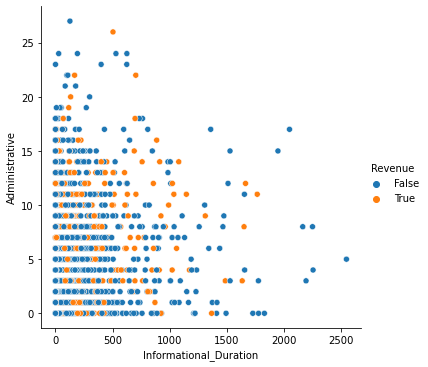

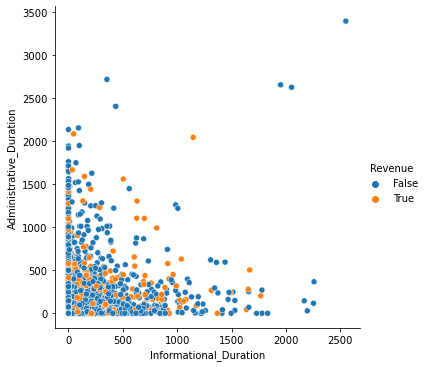

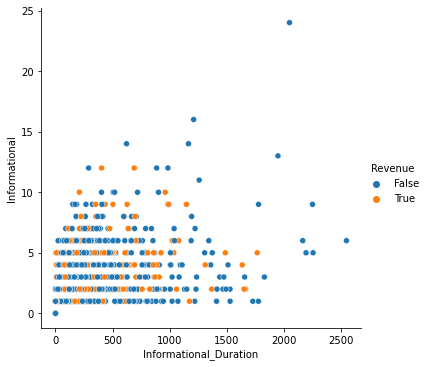

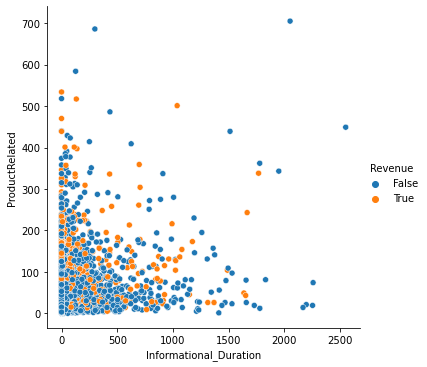

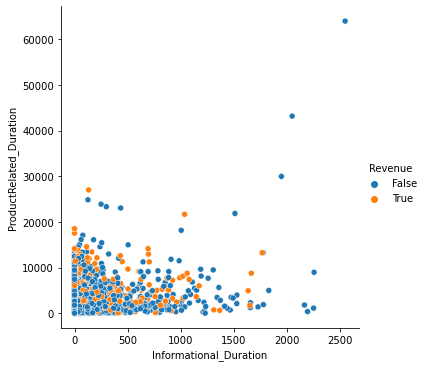

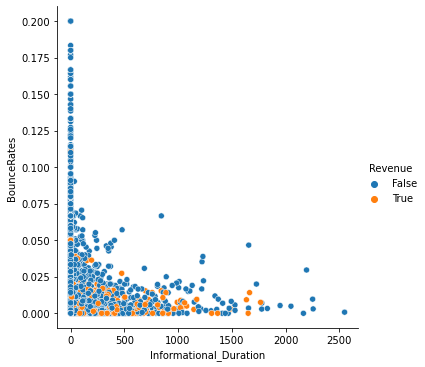

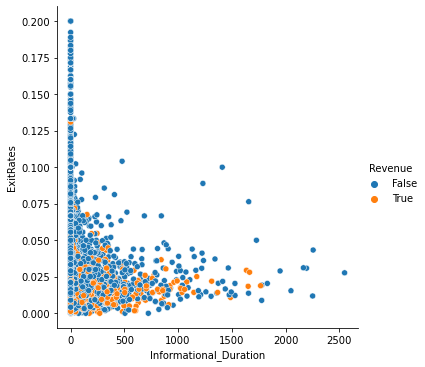

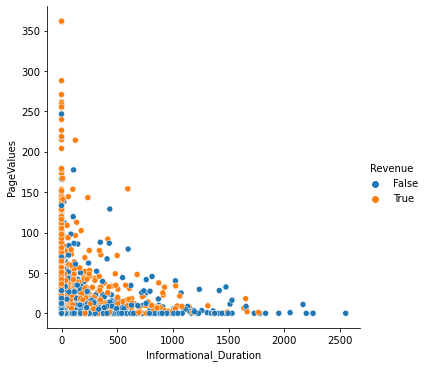

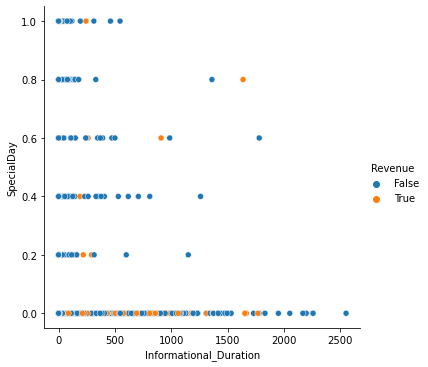

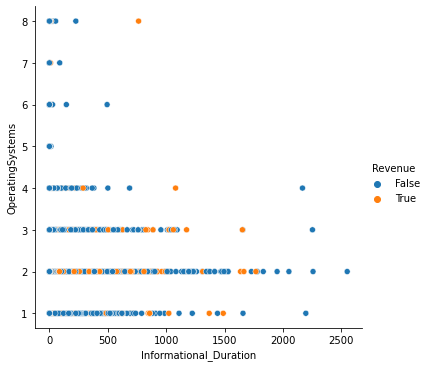

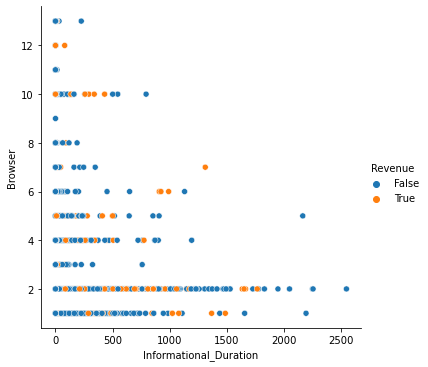

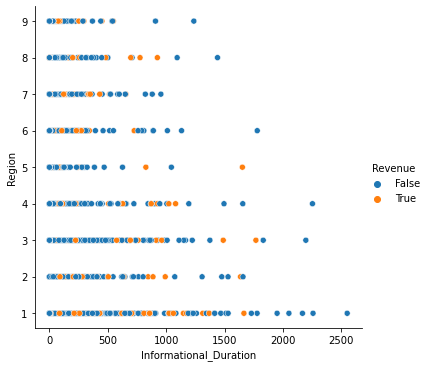

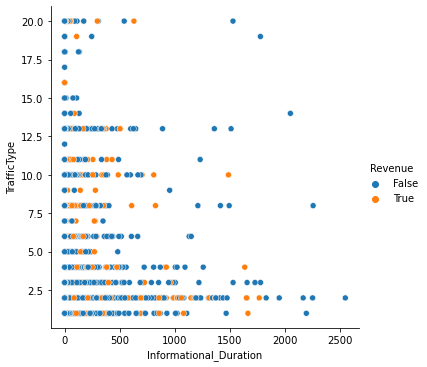

In [47]:
for col in numeric_col:
    if col != 'Informational_Duration':
        sns.relplot(data=data,
                    x='Informational_Duration',
                    y=col,
                    hue='Revenue',
                    kind='scatter' 
                   )

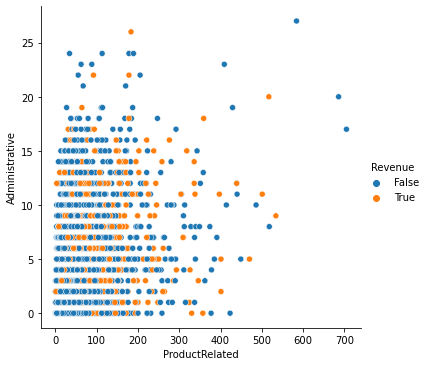

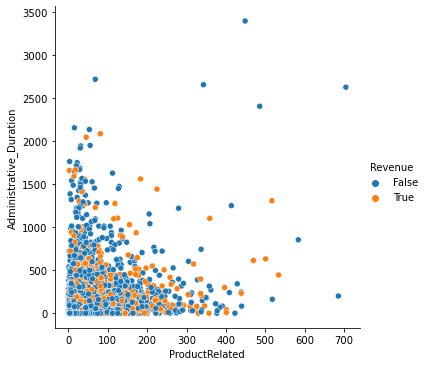

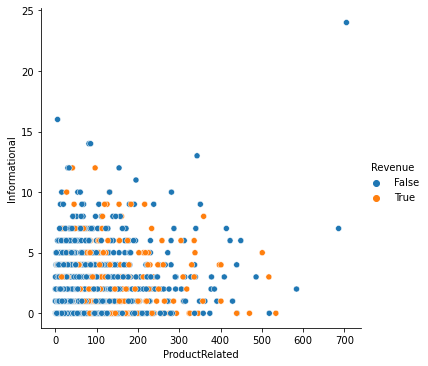

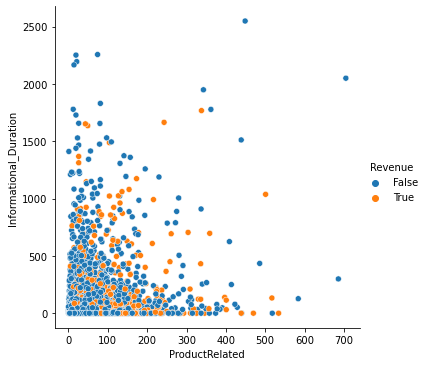

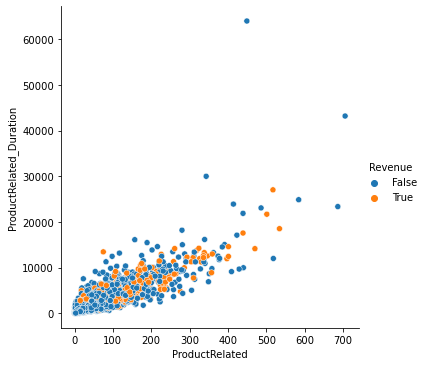

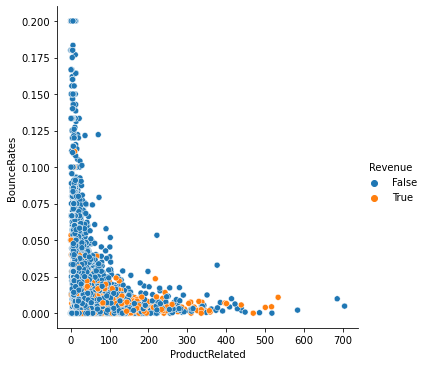

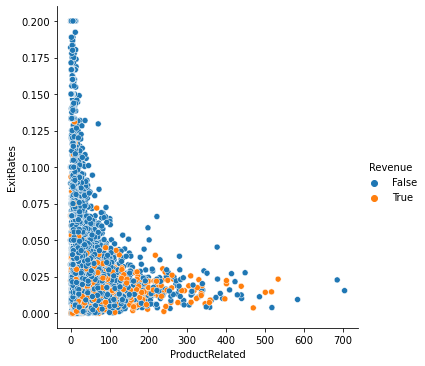

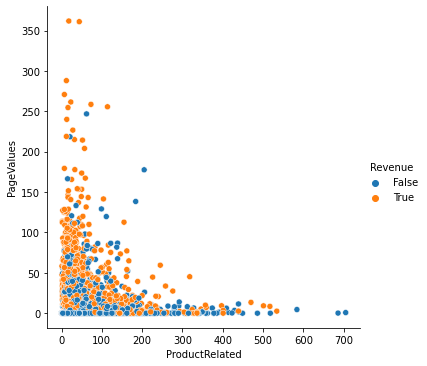

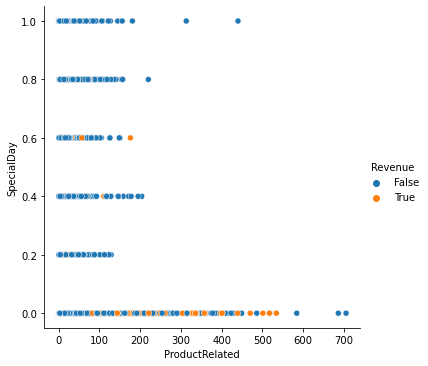

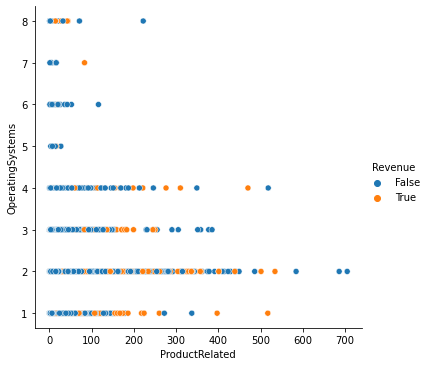

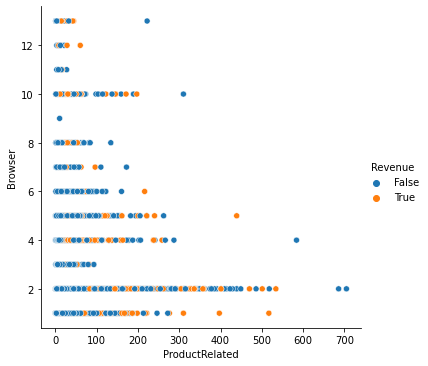

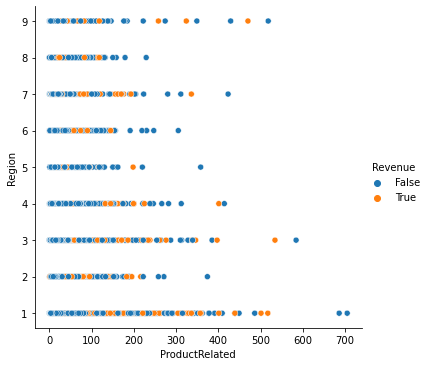

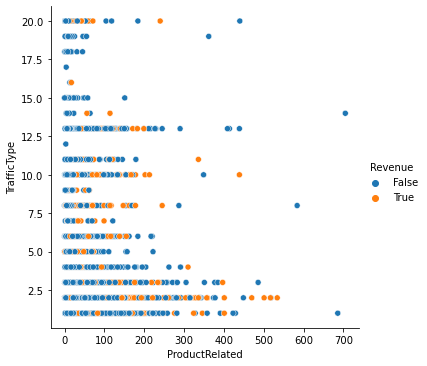

In [48]:
for col in numeric_col:
    if col != 'ProductRelated':
        sns.relplot(data=data,
                    x='ProductRelated',
                    y=col,
                    hue='Revenue',
                    kind='scatter' 
                   )

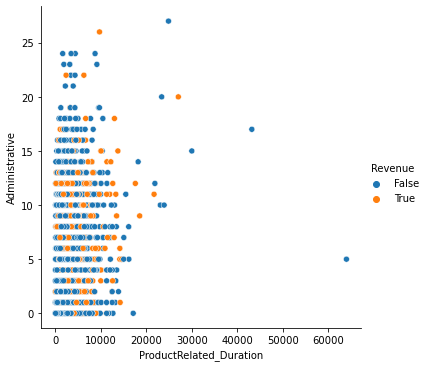

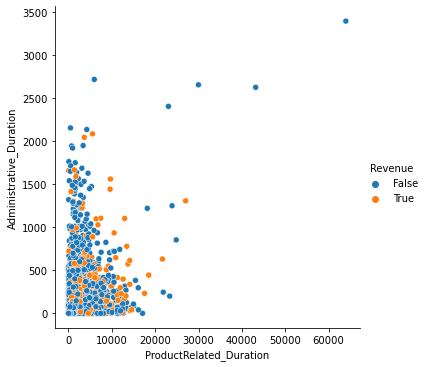

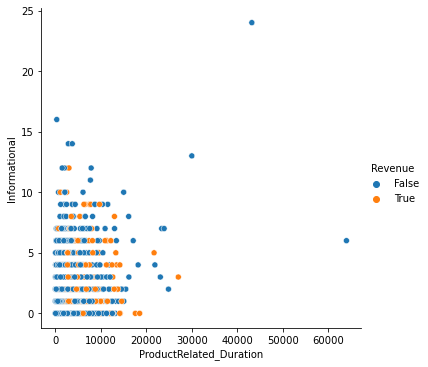

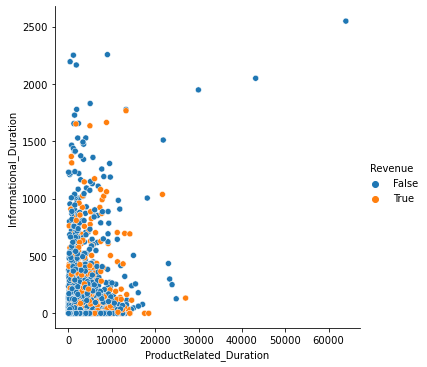

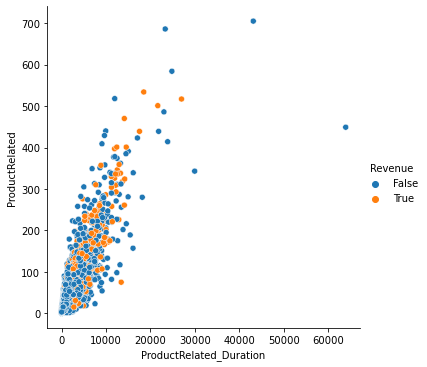

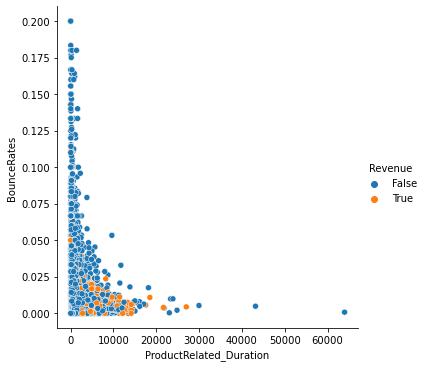

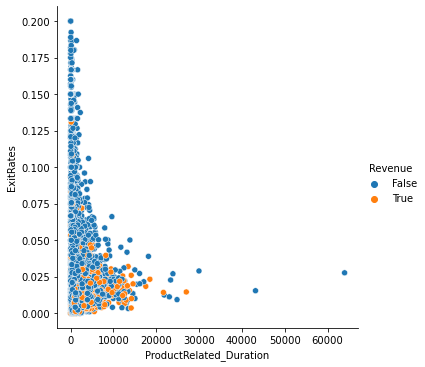

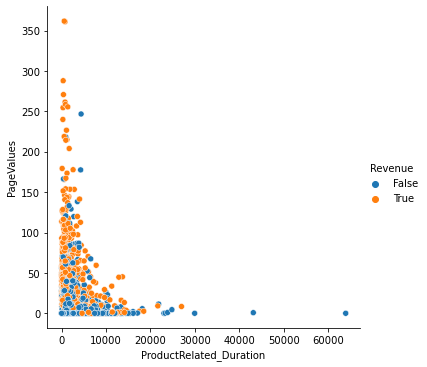

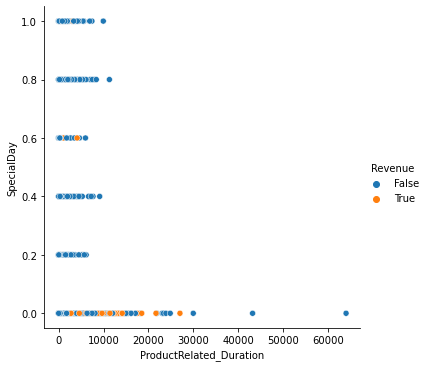

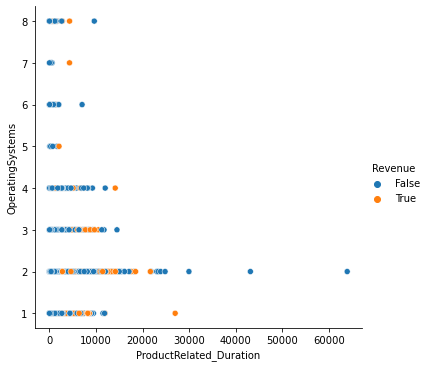

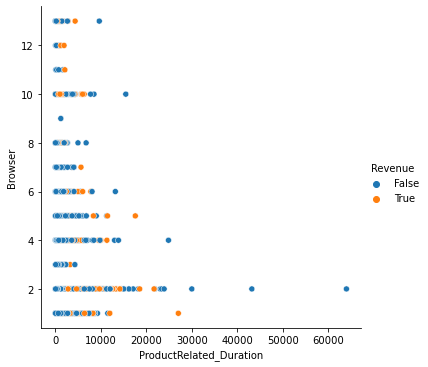

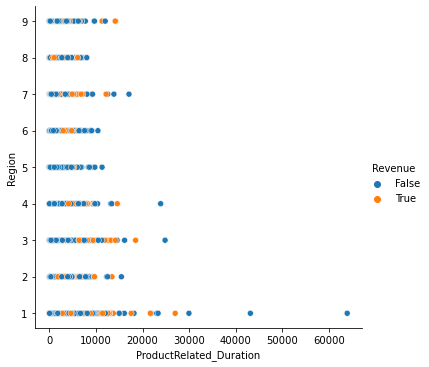

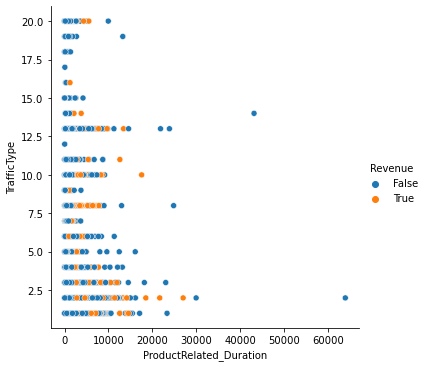

In [49]:
for col in numeric_col:
    if col != 'ProductRelated_Duration':
        sns.relplot(data=data,
                    x='ProductRelated_Duration',
                    y=col,
                    hue='Revenue',
                    kind='scatter' 
                   )

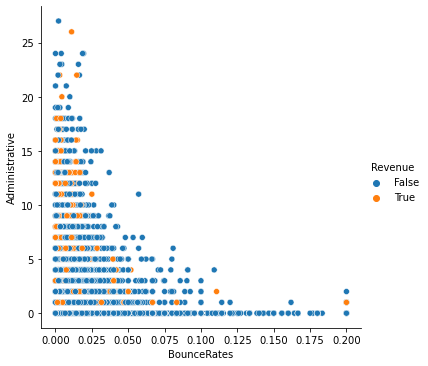

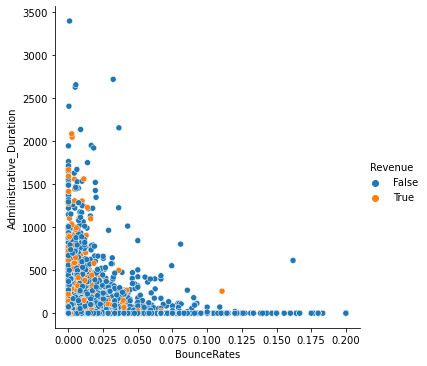

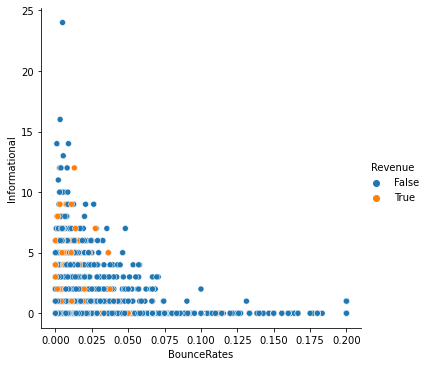

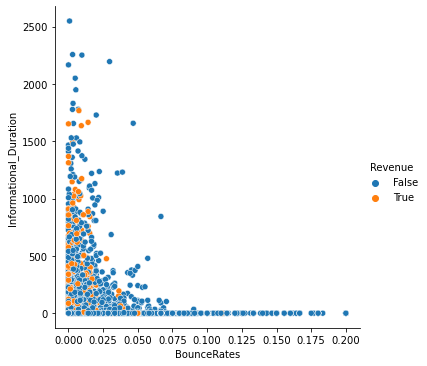

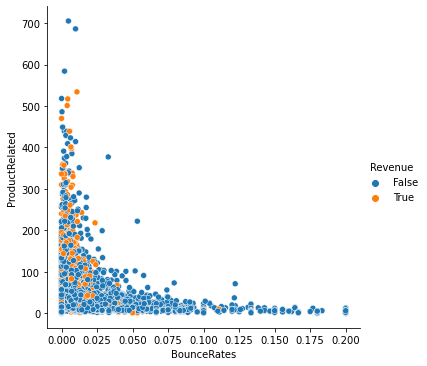

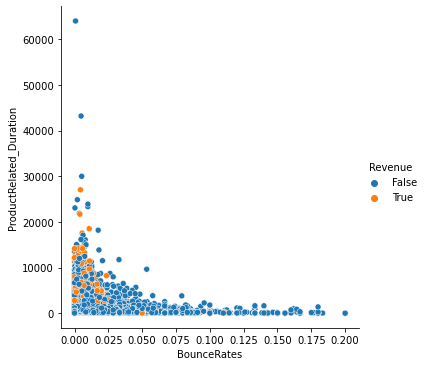

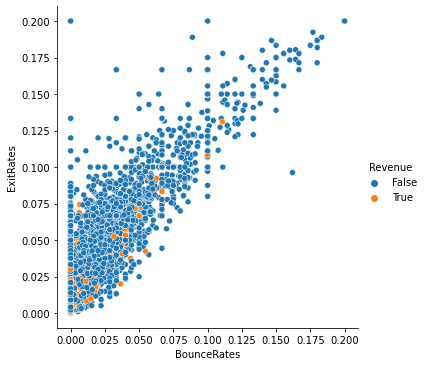

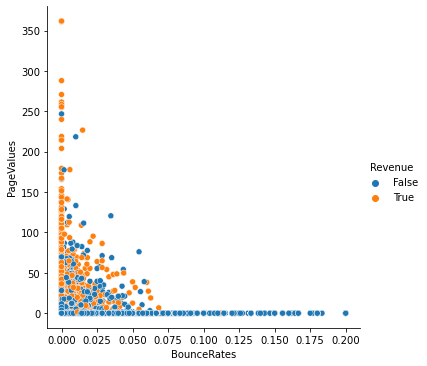

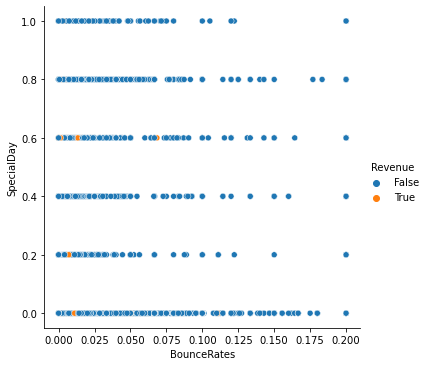

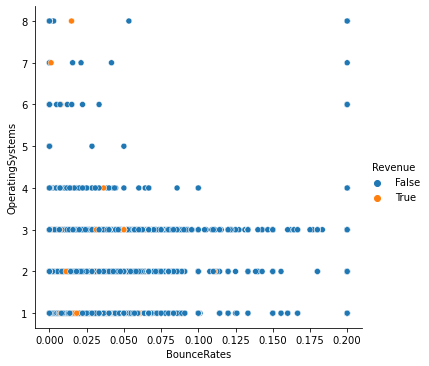

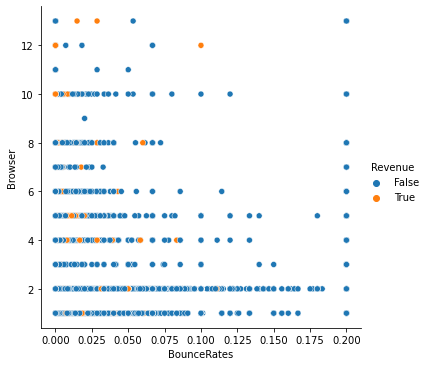

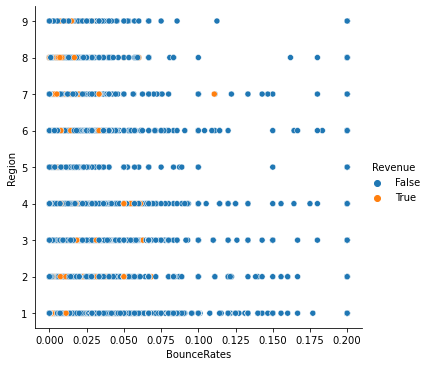

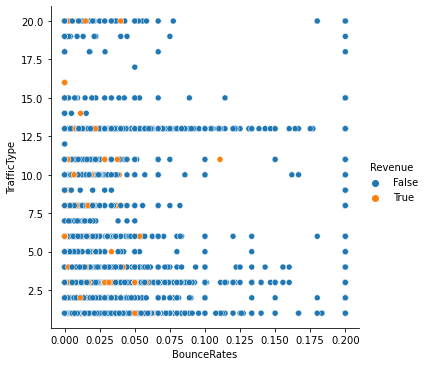

In [50]:
for col in numeric_col:
    if col != 'BounceRates':
        sns.relplot(data=data,
                    x='BounceRates',
                    y=col,
                    hue='Revenue',
                    kind='scatter' 
                   )

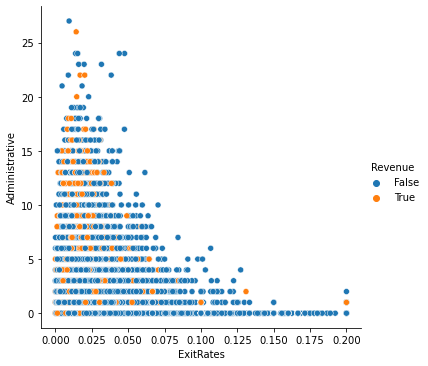

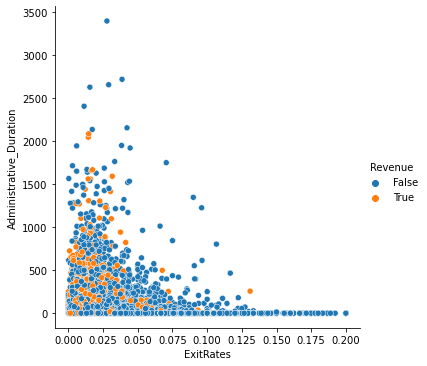

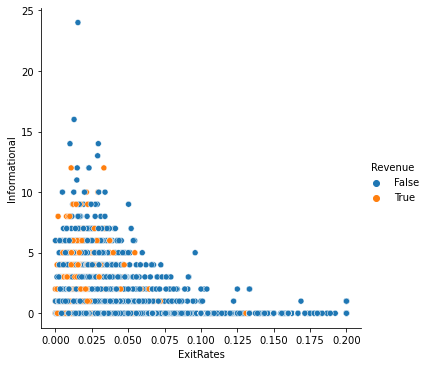

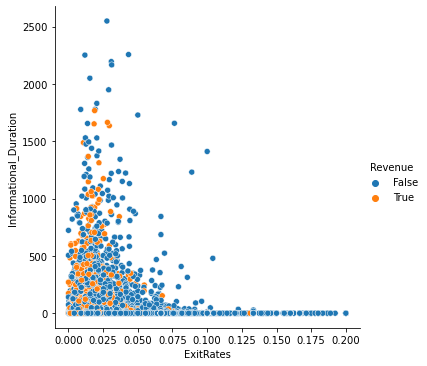

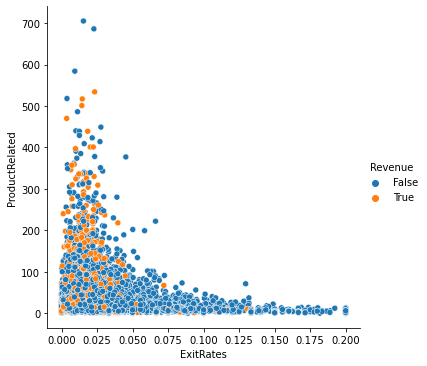

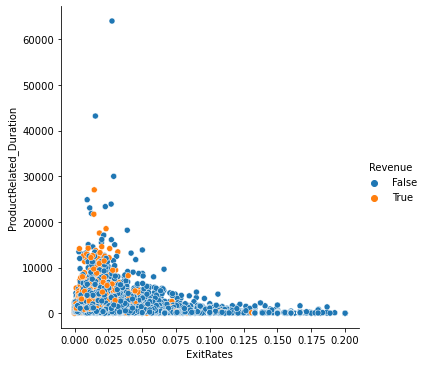

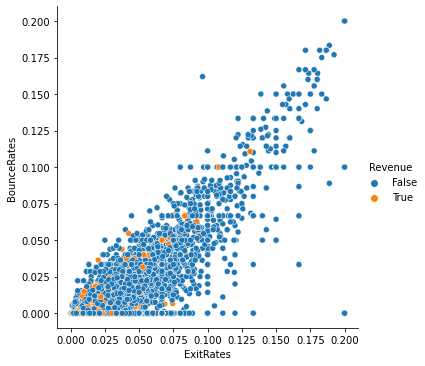

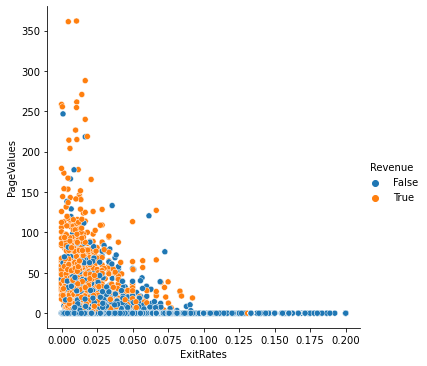

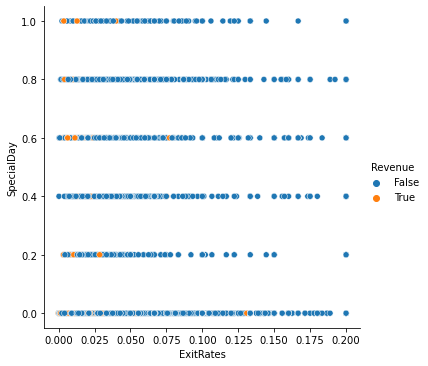

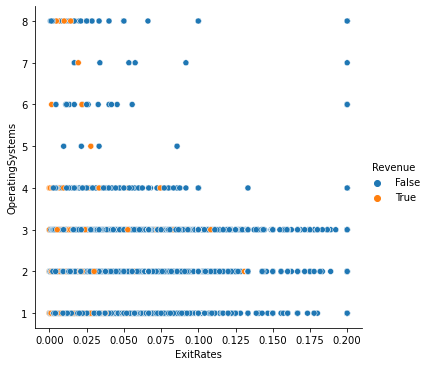

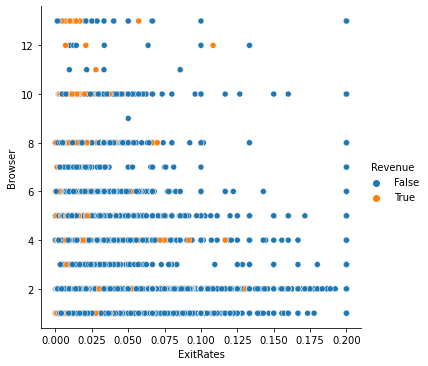

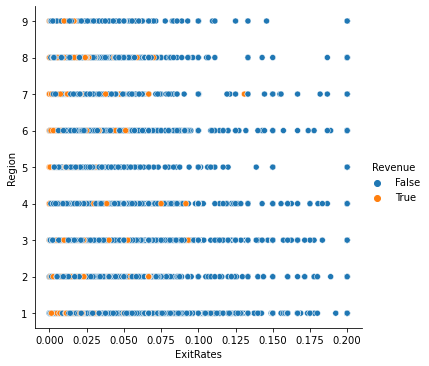

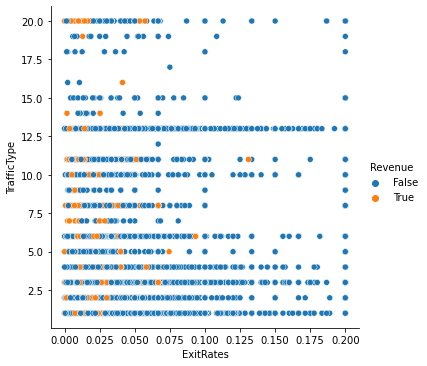

In [74]:
for col in numeric_col:
    if col != 'ExitRates':
        sns.relplot(data=data,
                    x='ExitRates',
                    y=col,
                    hue='Revenue',
                    kind='scatter' 
                   )

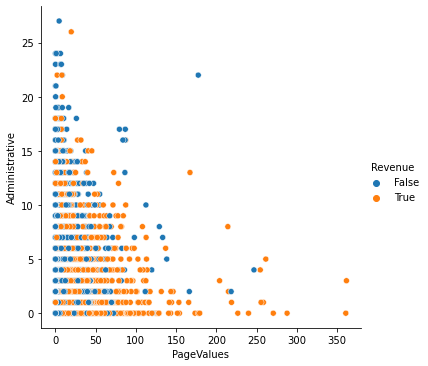

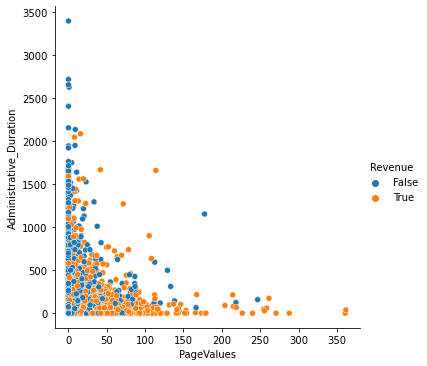

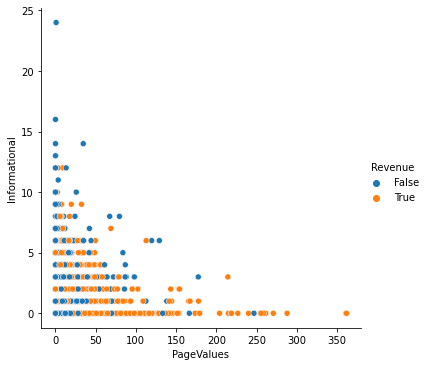

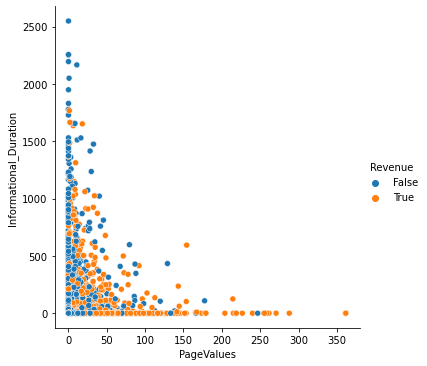

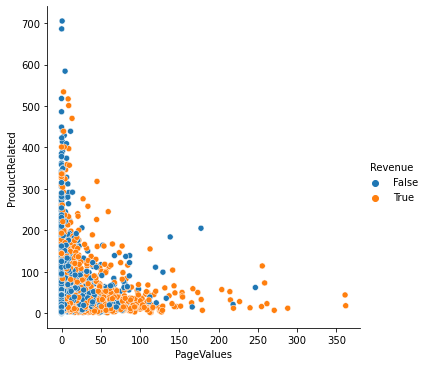

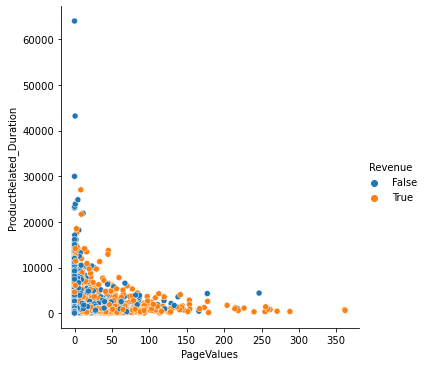

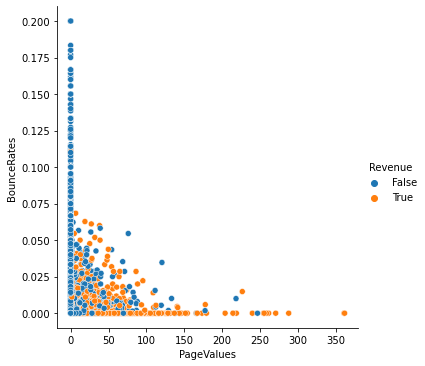

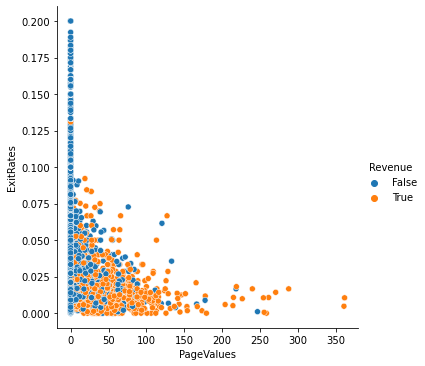

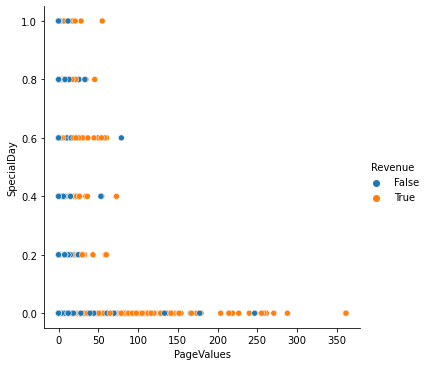

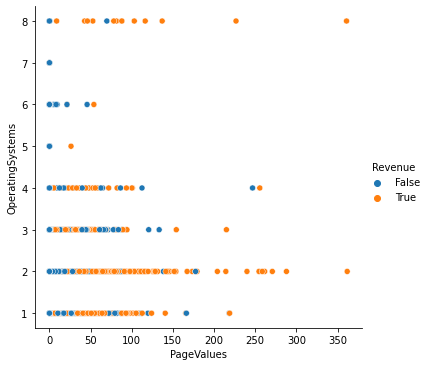

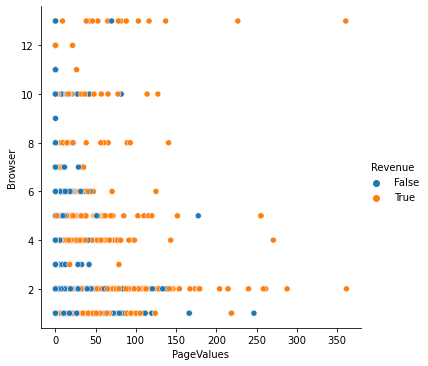

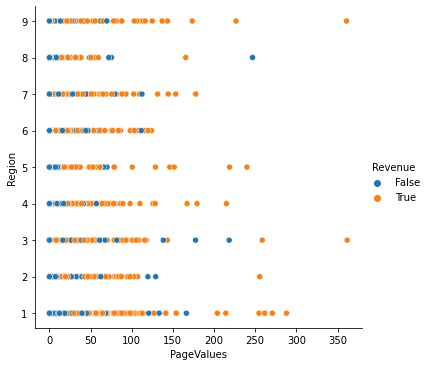

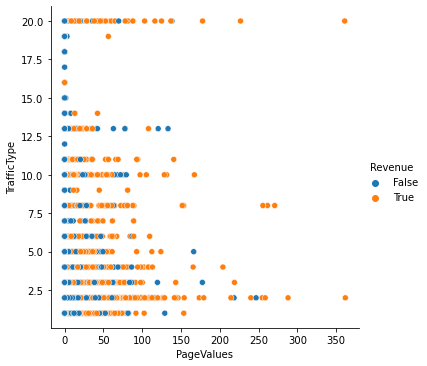

In [75]:
for col in numeric_col:
    if col != 'PageValues':
        sns.relplot(data=data,
                    x='PageValues',
                    y=col,
                    hue='Revenue',
                    kind='scatter' 
                   )

In [76]:
data

Administrative  Administrative_Duration  Informational  \
0                   0                      0.0              0   
1                   0                      0.0              0   
2                   0                      0.0              0   
3                   0                      0.0              0   
4                   0                      0.0              0   
...               ...                      ...            ...   
12325               3                    145.0              0   
12326               0                      0.0              0   
12327               0                      0.0              0   
12328               4                     75.0              0   
12329               0                      0.0              0   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                         0.0               1                 0.000000   
1                         0.0               2                64.000000   
2                         0.0               1                 0.000000   
3                         0.0               2                 2.666667   
4                         0.0              10               627.500000   
...                       ...             ...                      ...   
12325                     0.0              53              1783.791667   
12326                     0.0               5               465.750000   
12327                     0.0               6               184.250000   
12328                     0.0              15               346.000000   
12329                     0.0               3                21.250000   

       BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.200000   0.200000    0.000000         0.0   Feb                 1   
1         0.000000   0.100000    0.000000         0.0   Feb                 2   
2         0.200000   0.200000    0.000000         0.0   Feb                 4   
3         0.050000   0.140000    0.000000         0.0   Feb                 3   
4         0.020000   0.050000    0.000000         0.0   Feb                 3   
...            ...        ...         ...         ...   ...               ...   
12325     0.007143   0.029031   12.241717         0.0   Dec                 4   
12326     0.000000   0.021333    0.000000         0.0   Nov                 3   
12327     0.083333   0.086667    0.000000         0.0   Nov                 3   
12328     0.000000   0.021053    0.000000         0.0   Nov                 2   
12329     0.000000   0.066667    0.000000         0.0   Nov                 3   

       Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0            1       1            1  Returning_Visitor    False    False  
1            2       1            2  Returning_Visitor    False    False  
2            1       9            3  Returning_Visitor    False    False  
3            2       2            4  Returning_Visitor    False    False  
4            3       1            4  Returning_Visitor     True    False  
...        ...     ...          ...                ...      ...      ...  
12325        6       1            1  Returning_Visitor     True    False  
12326        2       1            8  Returning_Visitor     True    False  
12327        2       1           13  Returning_Visitor     True    False  
12328        2       3           11  Returning_Visitor    False    False  
12329        2       1            2        New_Visitor     True    False  

[12330 rows x 18 columns]

In [148]:
cat_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

In [81]:

X = data.drop('Revenue', axis=1)
y = data.Revenue.values.astype(np.int32)

In [127]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=23)

## 2.1 Train, test split

In [142]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23)

In [170]:
clf = CatBoostClassifier(n_estimators=200,
                         depth=4,
                         l2_leaf_reg=0.2,
                         min_child_samples=10,
                         verbose=False,
                         random_state=23,
                         eval_metric='AUC',
                         custom_metric=['Logloss',
                                        'AUC',
                                        'Accuracy'],
                        )

In [171]:
clf.fit(X_train,
        y=y_train,
        cat_features=cat_features,
        use_best_model=True,
        eval_set=(X_val, y_val),
        early_stopping_rounds=40,
        verbose=False,
        plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [172]:
print(clf.get_best_score())

{'learn': {'Accuracy': 0.9107036374478235, 'Logloss': 0.2212472893164131}, 'validation': {'Accuracy': 0.9015513126491647, 'Logloss': 0.22913483891661776, 'AUC': 0.9320278035874366}}


In [173]:
print(
    "accuracy score --", accuracy_score(clf.predict_proba(X_test).argmax(axis=1), y_test),
    "roc auc score --", roc_auc_score(clf.predict(X_test), y_test)
)

accuracy score -- 0.9147286821705426 roc auc score -- 0.8538987688098496


## 2.2 KFold

In [167]:
n_splits = 5
clfs = []
acc_scores = []
auc_scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=23)

for num, (train_index, test_index) in enumerate(kf.split(X=X, y=y)):

    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]

    clf = CatBoostClassifier(
                         max_depth=6,
                         n_estimators=200,
                         verbose=False,
                         random_state=23,
                         eval_metric='AUC',
                         custom_metric=['Logloss',
                                        'AUC',
                                        'Accuracy'],)
    clfs.append(clf)

    clf.fit(X_train,
            y_train,
            cat_features=cat_features,
            verbose=False)

    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_pred, y_val)
    auc = roc_auc_score(y_pred, y_val)
    acc_scores.append(acc)
    auc_scores.append(auc)
    
    print(f"fold {num}: acc: {acc}, auc: {auc}")

assert len(clfs) == n_splits
print(
    "mean accuracy score --", np.mean(acc_scores, dtype="float16"),
    "mean roc auc score --", np.mean(auc_scores, dtype="float16"),
)

fold 0: acc: 0.9141323792486583, auc: 0.8550345700652449
fold 1: acc: 0.902206320810972, auc: 0.8278167299639693
fold 2: acc: 0.8950506857483602, auc: 0.8065981581658144
fold 3: acc: 0.900417412045319, auc: 0.8212497045502456
fold 4: acc: 0.8967780429594272, auc: 0.8145228350548952
mean accuracy score -- 0.9014 mean roc auc score -- 0.825


In [169]:
pred = np.zeros(shape=(len(X_test), 2))
for n, model in enumerate(clfs):
    pred += model.predict_proba(X_test)
#pred = clfs[0].predict_proba(X_test)
last_pred = list(map(f, pred.argmax(axis=1)))
print(
    "accuracy score --", accuracy_score(last_pred, y_test),
    "roc auc score --", roc_auc_score(last_pred, y_test)
)

accuracy score -- 0.9409660107334525 roc auc score -- 0.9140354421611637
